In [1]:
from prepaid_option import PrepaidOption
from credit import Credit
from holee import HoLee, holee_forwards, holee_spots
import numpy as np

In [2]:
N = 12*1
r00 = 0.04761
dt = 1/12
volat = 0.0016835430755297832
# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    df = np.array(discount_factors)

holee_tree = HoLee(N, r00, dt, volat, df)
holee_tree.calibrate()

ann_r = 5/100
nom = 1_000_000
bullet = False
credito = Credit(dt, ann_r, N, nom, bullet)

opt_pre = PrepaidOption(credito, holee_tree)



In [3]:
opt_pre.opt_val

array([[1999.80054655, 1864.57274993, 1839.6894014 , 1793.01873871,
        1921.4340715 , 1528.36697914, 1172.00421093,  970.02312402,
         658.22869526,  407.48212332,  238.65582034,   82.04057374,
           0.        ],
       [   0.        , 1421.88625469, 1469.66295347, 1550.04364043,
        1677.63604993, 1338.28564294, 1029.09875647,  867.66008097,
         589.82858054,  366.34545428,  218.03354852,   75.15115026,
           0.        ],
       [   0.        ,    0.        , 1181.17095042, 1307.2380925 ,
        1433.96890414, 1148.29617277,  886.25471434,  765.33554592,
         521.45052822,  325.21984617,  197.41571469,   68.26283912,
           0.        ],
       [   0.        ,    0.        ,    0.        , 1064.60196724,
        1190.43254713,  958.39851307,  743.47205114,  663.04950025,
         453.09452894,  284.10529496,  176.80231751,   61.37564005,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         947.0268919

In [4]:
opt_pre.cred_pval

array([[1001999.80054655,  920423.75762813,  838618.72242812,
         756258.51840809,  674116.49170283,  590916.75556213,
         507408.69595789,  423708.55263146,  339550.68695384,
         255104.51050284,  170389.44002964,   85334.30459545,
              0.        ],
       [      0.        ,  919981.07113289,  838248.6959802 ,
         755954.95560342,  673872.69368126,  590726.67422593,
         507265.79050342,  423606.1895884 ,  339482.28683912,
         255063.3738338 ,  170368.81775782,   85327.41517197,
              0.        ],
       [      0.        ,       0.        ,  837878.90764875,
         755651.57193388,  673629.02653547,  590536.68475576,
         507122.94646129,  423503.86505335,  339413.9087868 ,
         255022.24822569,  170348.19992399,   85320.52686083,
              0.        ],
       [      0.        ,       0.        ,       0.        ,
         755348.3672696 ,  673385.49017846,  590346.78709607,
         506980.16379809,  423401.57900768,  339345

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from math import comb

def binomial_expectation(A: np.ndarray) -> np.ndarray:
    """
    Esperanza en cada tenor suponiendo prob. neutrales p=0.5 (binomial).
    A debe ser triangular: A[i,j] definido para i<=j.
    Devuelve vector mu de largo n+1 (n = A.shape[0]-1).
    """
    n = A.shape[0] - 1
    mu = np.zeros(n + 1)
    for j in range(n + 1):
        vals = A[:j+1, j]                 # valores en la columna j
        coefs = np.array([comb(j, i) for i in range(j+1)], dtype=float)
        mu[j] = np.sum(coefs * vals) / (2.0**j)
    return mu

def plot_option_lattice(
    A: np.ndarray,
    dt: float,
    title: str = "Árbol de precios de opción de prepago",
    principal: float | None = None,      # si se pasa, normaliza a % del capital
    show_expectation: bool = True,
    node_ms: float = 1.8,
    edge_lw: float = 0.6,
):
    """
    Dibuja (i) la malla del árbol de A y (ii) la esperanza por tenor.
    - A: matriz triangular (N+1 x N+1) con NaN fuera de i<=j
    - dt: paso en años (ej: 1/12 si mensual)
    - principal: si no es None, divide A y la esperanza por 'principal' para graficar en %
    """
    n = A.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje X en años

    Y = A.copy()
    mu = binomial_expectation(A) if show_expectation else None

    if principal is not None:
        Y = Y / principal
        if mu is not None:
            mu = mu / principal

    fig, ax = plt.subplots(figsize=(9.5, 5.2))

    # --- aristas del lattice (malla roja) ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(Y[i, j]) and np.isfinite(Y[i, j+1]):
                ax.plot([T[j], T[j+1]], [Y[i, j], Y[i, j+1]], color="red", lw=edge_lw, alpha=0.9)
            if np.isfinite(Y[i, j]) and np.isfinite(Y[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [Y[i, j], Y[i+1, j+1]], color="red", lw=edge_lw, alpha=0.9)

    # --- nodos (puntos) ---
    for j in range(n + 1):
        y = Y[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=node_ms, color="red", alpha=0.9)

    # --- esperanza (línea azul) ---
    if show_expectation:
        ax.plot(T, mu, color="tab:blue", lw=2.0, label="Costo Esperado")

    # Formato de ejes
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Costo Opción" if principal is None else "Costo Opción / Capital")
    ax.set_title(title)

    # Si normalizamos por principal, usar eje Y en %
    if principal is not None:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))
        ax.set_ylim(bottom=0)

    ax.grid(True, alpha=0.25)
    if show_expectation:
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

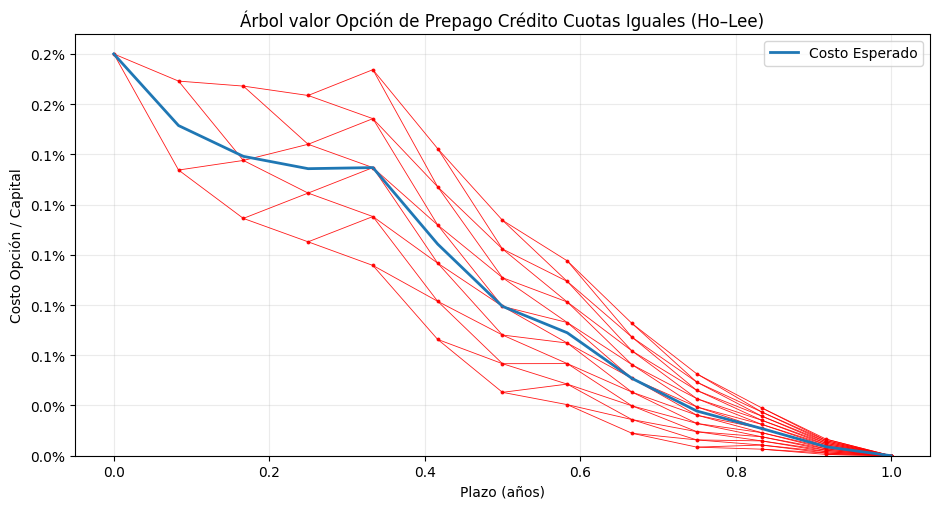

In [6]:
principal = nom

if bullet:
    titulo = "Árbol valor Opción de Prepago Crédito Bullet (Ho–Lee)"
else:
    titulo = "Árbol valor Opción de Prepago Crédito Cuotas Iguales (Ho–Lee)"

plot_option_lattice(
    opt_pre.opt_val,
    dt=dt,
    title=titulo,
    principal=principal,        # para que el eje Y sea %
    show_expectation=True
)


In [6]:
opt_pre.opt_val

array([[134467.15286485, 130837.53331159, 127211.09741023, ...,
             0.        ,      0.        ,      0.        ],
       [     0.        , 130829.18282079, 127202.77370251, ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        , 127194.4499917 , ...,
             0.        ,      0.        ,      0.        ],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [7]:
opt_pre.cred_pval

array([[1134467.15286485, 1130837.53331159, 1127211.09741023, ...,
         924324.77192177,  926461.96352895,       0.        ],
       [      0.        , 1130829.18282079, 1127202.77370251, ...,
         924317.59705678,  926450.3991593 ,       0.        ],
       [      0.        ,       0.        , 1127194.4499917 , ...,
         924310.42206837,  926438.83414353,       0.        ],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
         923908.42543905,  925790.16387622,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,  925778.56212937,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ]])

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value

from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")

    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    ax.set_title(f"{title} calibrado (NR) a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_ewma.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()

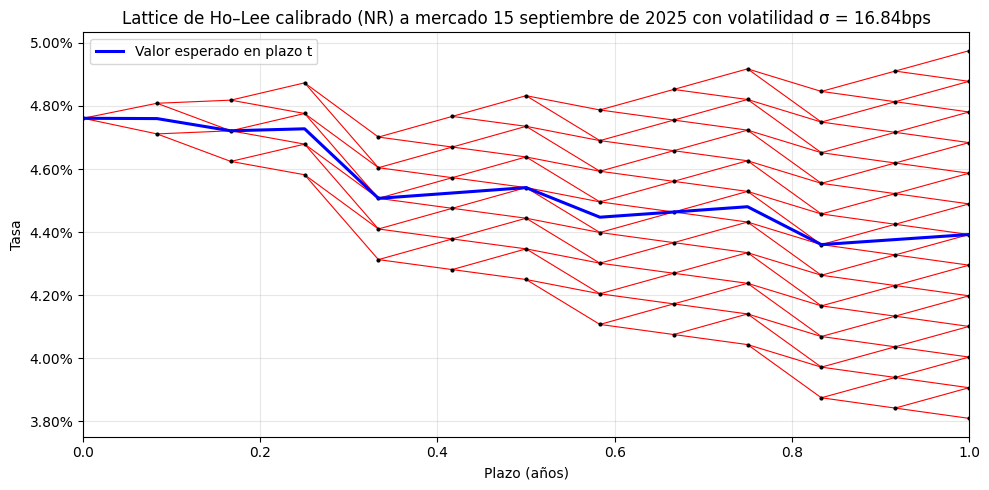

In [12]:

plot_ho_lee_lattice(holee_tree.r, dt=dt, sigma = volat, mostrar_esperanza=True)